In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving split_emails.csv to split_emails.csv
User uploaded file "split_emails.csv" with length 24004915 bytes


In [8]:
!pip install matplotlib

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD 
from sklearn.preprocessing import normalize 

In [0]:
emails = pd.read_csv('split_emails.csv')

In [0]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'), 
        'to': map_to_list(emails, 'to'), 
        'from_': map_to_list(emails, 'from')
    }

def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    

In [0]:

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
  if grp_ids:
      D = X[grp_ids].toarray()
  else:
      D = X.toarray()

  D[D < min_tfidf] = 0
  tfidf_means = np.mean(D, axis=0)
  return top_tfidf_feats(tfidf_means, features, top_n)

def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
  
class EmailDataset: 
  def __init__(self):
    stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
    self.vec = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)
    self.emails = read_email_bodies() 

    # train on the given email data.
    self.train()
  
  def train(self):
    self.vec_train = self.vec.fit_transform(self.emails)
  
  def query(self, keyword, limit):
    vec_keyword = self.vec.transform([keyword])
    cosine_sim = linear_kernel(vec_keyword, self.vec_train).flatten()
    related_email_indices = cosine_sim.argsort()[:-limit:-1]
    print(related_email_indices)
    return related_email_indices

  def find_email_by_index(self, i):
    return self.emails.as_matrix()[i]
  
def read_email_bodies():
  emails = pd.read_csv('split_emails.csv')
  email_df = pd.DataFrame(parse_into_emails(emails.message))
  email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)
  email_df.drop_duplicates(inplace=True)
  return email_df['body']

In [0]:
email_df = pd.DataFrame(parse_into_emails(emails.message))


In [0]:
email_df.drop(email_df.query("body == '' | to == '' | from_ == ''").index, inplace=True)


In [0]:
stopwords = ENGLISH_STOP_WORDS.union(['ect', 'hou', 'com', 'recipient'])
vect = TfidfVectorizer(analyzer='word', stop_words=stopwords, max_df=0.3, min_df=2)

X = vect.fit_transform(email_df.body)
features = vect.get_feature_names()

In [0]:
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
labels = clf.fit_predict(X)

In [0]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

In [0]:
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

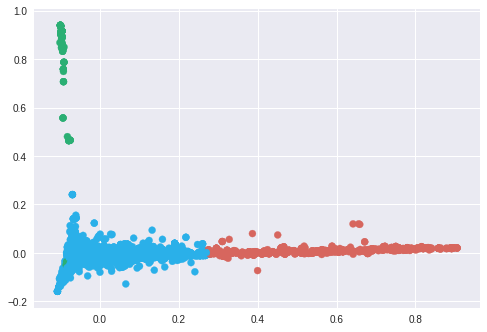

In [13]:
plt.scatter(coords[:, 0], coords[:, 1], c=colors)

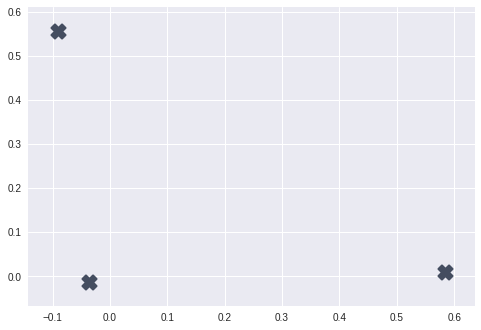

In [14]:
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()

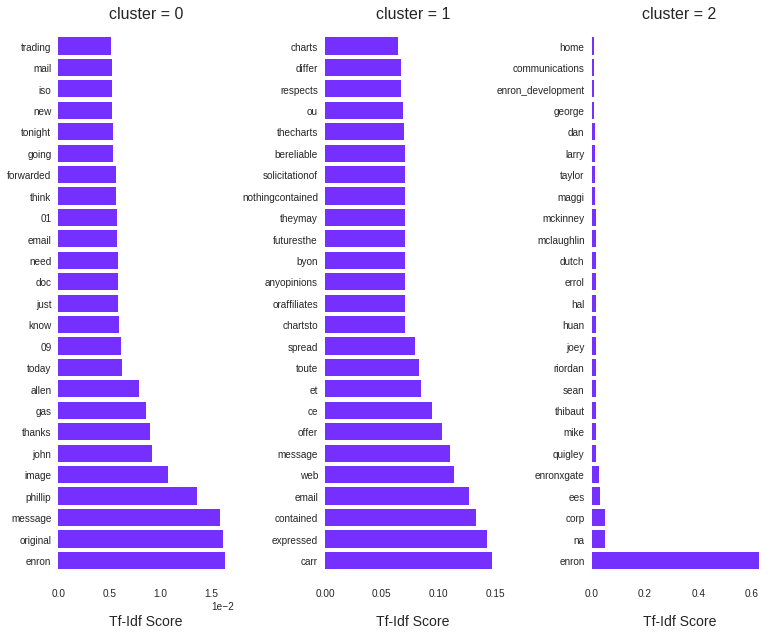

In [15]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))


In [0]:
##query

In [17]:
X

<9464x40965 sparse matrix of type '<class 'numpy.float64'>'
	with 634311 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import linear_kernel
import pandas as pd

In [0]:
# print(X[0:2])

In [0]:
cosine_sim = linear_kernel(X[0:1], X).flatten()

In [23]:
cosine_sim

array([1., 0., 0., ..., 0., 0., 0.])

In [0]:
# Finding emails related to a query.
query = "john"

# Transform the query into the original vector
vec_query = vect.transform([query])

In [0]:
cosine_sim = linear_kernel(vec_query, X).flatten()


In [0]:
# Find top 10 most related emails to the query.
related_email_indices = cosine_sim.argsort()[:-10:-1]


In [32]:
# print out the indices of the 10 most related emails.
print(related_email_indices)


[2162 5900 5839 6133 5570 7483 4707 3604 5549]


In [33]:
# print out the first email 
first_email_index = related_email_indices[0]
print(email_df.body.as_matrix()[first_email_index])


John,Do you still want to get together this week?Phillip


In [48]:
# use the EmailDataset class to query for keywords.
ds = EmailDataset()
results = ds.query('trade', 10)


[1991 3994 3911 2815 1990 1902 4747 3209 2172]


In [49]:
# Print out the first result.
print(ds.find_email_by_index(results[-2]))


seems to me trade guys are getting royally fucked in crude
